In [5]:
import random
import re
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch
import json

/opt/anaconda3/envs/hf/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Asnwer 4.1

In [6]:
model_name = "google/flan-t5-base"

def load_model():
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    loaded_model = AutoModelForSeq2SeqLM.from_pretrained(model_name)  # Use different variable name
    return tokenizer, loaded_model



### Answer for 4.2

In [7]:


n_samples = 200
random_seed=42
random.seed(random_seed)
def load_questions():
    dataset = load_dataset("derek-thomas/ScienceQA", split="train")

    filtered_dataset = []
    for i, item in enumerate(dataset):
        if(len(item['choices'])==4 and
           item['image'] is None and 
           item['question'].strip()):
            
            filtered_dataset.append({
                'id': i,
                'question': item['question'].strip(),
                'choices': [c.strip() for c in item['choices']],
                'answer': item['answer']
            })
    sampled = random.sample(filtered_dataset, min(n_samples, len(filtered_dataset)))
    return sampled


def question_formatting(questions_data):
    question_text = questions_data['question']
    choices = questions_data['choices']

    formatted = f"Question: {question_text}\nOptions:\n"
    for i, choice in enumerate(choices):
        formatted += f"({chr(65 + i)}) {choice}\n"
    return formatted.strip()

### 4.3 Baseline model

In [8]:
def create_baseline_prompt(questions_data):
    return question_formatting(questions_data) + "\nAnswer:"

def run_baseline(tokenizer, model, questions):
    predictions = []

    for i, q in enumerate(questions):
        prompt = create_baseline_prompt(q)
        inputs = tokenizer(prompt, return_tensors="pt")
        outputs = model.generate(**inputs, max_new_tokens=10)
        response = tokenizer.decode(outputs[0], skip_special_tokens=True)

        predicted_answer = extract_answer_letter(response)

        predictions.append({
            'id': q['id'],
            'predicted_answer': predicted_answer,
            'raw_response': response,
            'correct_asswer': chr(65 + q['answer'])
        })

        if (i + 1) % 20 == 0:
            print(f"Baseline: Processed {i + 1}/{len(questions)} questions")
    return predictions

### 4.4 Prompt with CoT

In [9]:

def create_CoT_prompt(questions_data):
    CoT_instruction = """You are a careful reasoning assistant that answers multiple-choice questions about science. First, think step by step. Then, give the final answer. Format exactly as:
Reasoning: <step 1>
Reasoning: <step 2>
Reasoning: <step 3>
Answer: <final letter>

"""
    return CoT_instruction + question_formatting(questions_data)

def run_CoT(tokenizer, model, questions_data):
    predictions = []

    for i, q in enumerate(questions_data):
        prompt = create_CoT_prompt(q)

        inputs = tokenizer(prompt, return_tensors="pt")
        outputs = model.generate(**inputs, max_new_tokens=200)
        response = tokenizer.decode(outputs[0], skip_special_tokens=True)

        reasoning_steps = extract_reasoning_steps(response)
        predicted_answer = extract_answer_letter(response)


        predictions.append({
            'id': q['id'],
            'reasoning_steps': reasoning_steps,
            'predicted_answer': predicted_answer,
            'raw_response': response,
            'correct_asswer': chr(65 + q['answer'])
        })

        if (i + 1) % 20 == 0:
            print(f"CoT: Processed {i + 1}/{len(questions_data)} questions")
    return predictions

def extract_answer_letter(response):
   
    response_upper = response.upper()
    
    match = re.search(r'ANSWER\s*:\s*\(?([A-D])\)?', response_upper)
    if match:
        return match.group(1)
    
    match = re.search(r'\(?([A-D])\)', response_upper)
    if match:
        return match.group(1)
    
    letters_found = re.findall(r'\b([A-D])\b', response_upper)
    if letters_found:
        return letters_found[-1]
    
    for letter in ['A', 'B', 'C', 'D']:
        if letter in response_upper:
            return letter
    
    return None


def extract_reasoning_steps(response):
    """Extract first 3 reasoning steps with better error handling."""
    if not response:
        return []
    
    reasoning_steps = []
    
    lines = response.split('\n')
    for line in lines:
        if 'reasoning:' in line.lower():
            # Extract text after "Reasoning:"
            if ':' in line:
                step = line.split(':', 1)[1].strip()
                if step:  # Only add non-empty steps
                    reasoning_steps.append(step)
                    if len(reasoning_steps) == 3:
                        break
    
    # If we found 3 reasoning steps, we're done
    if len(reasoning_steps) >= 3:
        return reasoning_steps[:3]
    
    # Strategy 2 (Fallback): Extract text before answer
    # Try multiple patterns for "answer"
    text_before_answer = response
    for pattern in [r'answer\s*:', r'answer\s+is', r'answer\s*=', r'the answer']:
        parts = re.split(pattern, response, maxsplit=1, flags=re.IGNORECASE)
        if len(parts) > 1:
            text_before_answer = parts[0]
            break
    
    # Split into sentences (handle multiple punctuation marks)
    sentences = re.split(r'[.!?]+', text_before_answer)
    sentences = [s.strip() for s in sentences if s.strip() and len(s.strip()) > 5]
    
    # Add what we need to reach 3 total steps
    needed = 3 - len(reasoning_steps)
    reasoning_steps.extend(sentences[:needed])
    
    # Pad with empty strings if we still don't have 3
    while len(reasoning_steps) < 3:
        reasoning_steps.append("[No reasoning provided]")
    
    return reasoning_steps[:3]


### 4.5

In [ ]:
def analyze_flips(baseline_preds, cot_preds, questions):
    
    categories = {
        'Flip-to-correct': [],
        'Flip-to-incorrect': [],
        'Correct-Correct': [],
        'Incorrect-Incorrect': []
    }
    
    for q, base_pred, cot_pred in zip(questions, baseline_preds, cot_preds):
        correct_ans = chr(65 + q['answer'])
        base_correct = (base_pred['predicted_answer'] == correct_ans)
        cot_correct = (cot_pred['predicted_answer'] == correct_ans)

        if not base_correct and cot_correct:
            category = 'Flip-to-correct'
        elif base_correct and not cot_correct:
            category = 'Flip-to-incorrect'
        elif base_correct and cot_correct:
            category = 'Correct-Correct'
        else:
            category = 'Incorrect-Incorrect'
        
        categories[category].append({
            'question': q,
            'baseline': base_pred,
            'cot': cot_pred
        })
    
    total = len(questions)
    baseline_correct = sum(1 for bp, q in zip(baseline_preds, questions) 
                          if bp['predicted_answer'] == chr(65 + q['answer']))
    cot_correct = sum(1 for cp, q in zip(cot_preds, questions) 
                     if cp['predicted_answer'] == chr(65 + q['answer']))
    
    baseline_acc = baseline_correct / total
    cot_acc = cot_correct / total
    
    print("\nCategory Counts:")
    for cat, items in categories.items():
        print(f"  {cat}: {len(items)} ({len(items)/total*100:.1f}%)")
    
    print(f"\nAccuracy:")
    print(f"  Baseline: {baseline_acc:.2%} ({baseline_correct}/{total})")
    print(f"  CoT:      {cot_acc:.2%} ({cot_correct}/{total})")
    print(f"  Change:   {(cot_acc - baseline_acc):+.2%}")
    print()
    
    return categories, baseline_acc, cot_acc


def visualize_flips_with_CoT(categories):
    counts = [len(categories[cat]) for cat in [
        'Flip-to-correct', 'Flip-to-incorrect', 
        'Correct-Correct', 'Incorrect-Incorrect'
    ]]
    labels = ['Flip-to-correct', 'Flip-to-incorrect', 
              'Correct-Correct', 'Incorrect-Incorrect']
    colors = ['green', 'red', 'blue', 'gray']
    
    plt.figure(figsize=(10, 6))
    plt.bar(labels, counts, color=colors, alpha=0.7, edgecolor='black')
    plt.xlabel('Category', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.title('Chain-of-Thought Impact on Predictions', fontsize=14)
    plt.xticks(rotation=15, ha='right')
    
    for i, (count, label) in enumerate(zip(counts, labels)):
        plt.text(i, count + 2, str(count), ha='center', fontsize=11)
    
    plt.tight_layout()
    plt.savefig('cot_flip_analysis.png', dpi=300)
    plt.show()
    print("✓ Visualization saved as 'cot_flip_analysis.png'\n")






### 4.6

In [11]:

def qualitative_inspection(categories, n_samples=20):
    print("="*60)
    print("QUALITATIVE INSPECTION")
    print("="*60)
    
    for category, items in categories.items():
        print(f"\n{category} ({len(items)} total)")
        print("-" * 60)
        
        sample = random.sample(items, min(n_samples, len(items)))
        
        for i, item in enumerate(sample[:3], 1):
            q = item['question']
            print(f"\nExample {i}:")
            print(f"Q: {q['question']}")
            print(f"Choices: {q['choices']}")
            print(f"Correct: {chr(65 + q['answer'])}")
            print(f"Baseline → {item['baseline']['predicted_answer']}")
            print(f"CoT      → {item['cot']['predicted_answer']}")
            
            if item['cot']['reasoning_steps']:
                print("CoT Reasoning:")
                for j, step in enumerate(item['cot']['reasoning_steps'], 1):
                    print(f"  {j}. {step}")
        
        if len(sample) > 3:
            print(f"\n... and {len(sample) - 3} more examples")


### Main excecution

/opt/anaconda3/envs/hf/lib/python3.11/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


Baseline: Processed 20/200 questions
Baseline: Processed 40/200 questions
Baseline: Processed 60/200 questions
Baseline: Processed 80/200 questions
Baseline: Processed 100/200 questions
Baseline: Processed 120/200 questions
Baseline: Processed 140/200 questions
Baseline: Processed 160/200 questions
Baseline: Processed 180/200 questions
Baseline: Processed 200/200 questions
CoT: Processed 20/200 questions
CoT: Processed 40/200 questions
CoT: Processed 60/200 questions
CoT: Processed 80/200 questions
CoT: Processed 100/200 questions
CoT: Processed 120/200 questions
CoT: Processed 140/200 questions
CoT: Processed 160/200 questions
CoT: Processed 180/200 questions
CoT: Processed 200/200 questions

Category Counts:
  Flip-to-correct: 38 (19.0%)
  Flip-to-incorrect: 12 (6.0%)
  Correct-Correct: 65 (32.5%)
  Incorrect-Incorrect: 85 (42.5%)

Accuracy:
  Baseline: 38.50% (77/200)
  CoT:      51.50% (103/200)
  Change:   +13.00%



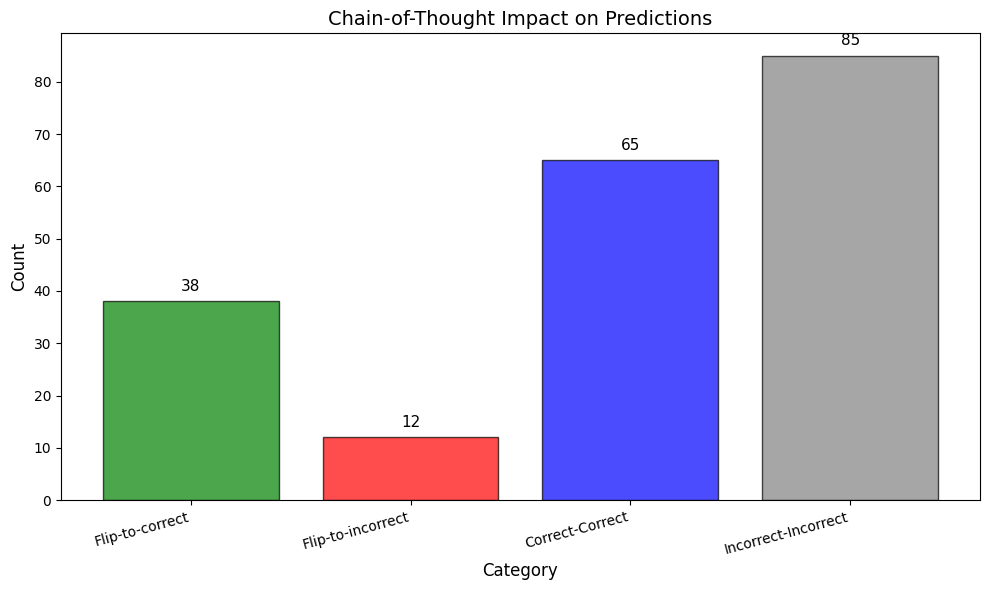

✓ Visualization saved as 'cot_flip_analysis.png'

QUALITATIVE INSPECTION

Flip-to-correct (38 total)
------------------------------------------------------------

Example 1:
Q: Which organ controls what the body's organs do?
Choices: ['skin', 'lungs', 'brain', 'heart']
Correct: C
Baseline → A
CoT      → C
CoT Reasoning:
  1. Brain controls what the body's organs do
  2. The final
  3. [No reasoning provided]

Example 2:
Q: How long is a bench?
Choices: ['9 miles', '9 feet', '9 inches', '9 yards']
Correct: B
Baseline → A
CoT      → B
CoT Reasoning:
  1. A bench is 9 inches long
  2. The final
  3. [No reasoning provided]

Example 3:
Q: Which type of sentence is this?
Isaac took several incredible panoramic photographs of the sweeping view from the top of Table Mountain.
Choices: ['complex', 'compound-complex', 'compound', 'simple']
Correct: D
Baseline → A
CoT      → D
CoT Reasoning:
  1. Table Mountain is a mountain
  2. The panoramic photographs are taken from the top of the mountain
 

In [12]:
def main():
   
    
    tokenizer, model= load_model()
    questions = load_questions()
    baseline_preds = run_baseline(tokenizer, model, questions)
    cot_preds = run_CoT(tokenizer, model, questions)

    categories, baseline_acc, cot_acc = analyze_flips(baseline_preds, cot_preds, questions)
    visualize_flips(categories)

    qualitative_inspection(categories, n_samples=20)

    results = {
        'model': model_name,
        'n_samples': n_samples,
        'baseline_accuracy': baseline_acc,
        'cot_accuracy': cot_acc,
        'categories': {k: len(v) for k, v in categories.items()}
    }
    
    with open('cot_analysis_results.json', 'w') as f:
        json.dump(results, f, indent=2)


if __name__ == "__main__":
    main()